<a href="https://colab.research.google.com/github/luyuzhe111/machine-learning-foundamentals/blob/main/locality_sensitive_hashing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import random
import math
from timeit import default_timer as timer

In [ ]:
drive.mount("/content/drive", force_remount=True)
path = "/content/drive/MyDrive/Colab Notebooks/hw3_p2.pkl"
with open(path, 'rb') as f:
    data = pickle.load(f)

Mounted at /content/drive


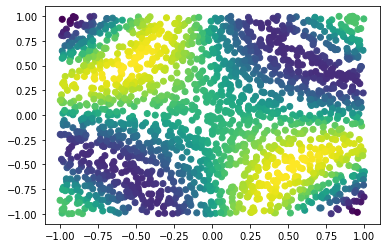

In [ ]:
x_train=data['x_train']
y_train=data['y_train']
x_test=data['x_test']
y_test=data['y_test']
n, dim = x_train.shape
test_size = y_test.shape[0]
d = [1,2,3,4,6]
gammas = [1,10,100,1000]
# visualize the training set
plt.scatter(x_train[:,0],x_train[:,1],c=y_train)
plt.show()

In [ ]:
class regressor:
    
    def __init__(self, kernel='rbf', degree=1, gamma=1):
        self.gamma = gamma
        self.degree = degree
        self.kernel = {'poly': lambda x, train_x, train_y: self.get_poly(x, train_x, train_y),
                       'rbf': lambda x, train_x, train_y: self.get_rbf(x, train_x, train_y),
                       'custom': lambda x, train_x, train_y: self.get_custom(x, train_x, train_y)}[kernel]

    def get_poly(self, x, train_x, train_y):
        kernel = np.power((1 + np.sum(x * train_x, axis=1)), self.degree)
        return np.sum(np.multiply(train_y, kernel)) / np.sum(kernel)

    def get_rbf(self, x, train_x, train_y):
        kernel = self.kernel_rbf(x, train_x)
        return np.sum(np.multiply(train_y, kernel)) / np.sum(kernel)

    def get_custom(self, x, train_x, train_y):
        rbf = self.kernel_rbf(x, train_x)
        bottom = 1 + rbf
        kernel = np.divide((-rbf), bottom)
        return np.sum(np.multiply(train_y, kernel)) / np.sum(kernel)

    def fit(self, train_x, train_y):
        self.train_x = train_x
        self.train_y = train_y
        self.hash_code, self.hash_table, self.hash_table_y = LSH(train_x, train_y)

    def kernel_rbf(self, x, train_x):
        return np.exp(-self.gamma * np.sum(np.square(x - train_x), axis=1))

    def get_custom_hash(self, x, hashing):
        rbf = np.exp(-self.gamma * np.sum(np.square(x - self.hash_table[hashing]), axis=1))
        bottom = 1 + rbf
        kernel = np.divide((-rbf), bottom)
        return np.sum(np.multiply(self.hash_table_y[hashing], kernel)) / np.sum(kernel)
    
    def get_MSE(self, test_y):
        return np.average(np.square(self.pred - test_y))

    def set_gamma(self, new_g):
        self.gamma = new_g

    def set_degree(self, new_d):
        self.degree = new_d
    
    def predict(self, test_x):
        test_size = test_x.shape[0]
        pred = np.zeros(test_size)
        for i in range(test_size):
            # a, b = self.compute_kernel_sum(test_x[i])
            pred[i] = self.kernel(test_x[i], self.train_x, self.train_y)
        self.pred = pred
        return pred

    def predict_hashing(self, test_x):
        test_size = test_x.shape[0]
        pred = np.zeros(test_size)
        for i in range(test_size):
            hashing = compute_hashing(test_x[i], self.hash_code)
            pred[i] = self.kernel(test_x[i], self.hash_table[hashing], self.hash_table_y[hashing])
        self.pred = pred
        return pred

    def plot_hashing(self):
        for i in self.hash_table:
            plt.scatter(self.hash_table[i][:, 0], self.hash_table[i][:, 1], c=self.hash_table_y[i])
            print(self.hash_table_y[i])
            plt.show()

Part1

Vanilla Regression

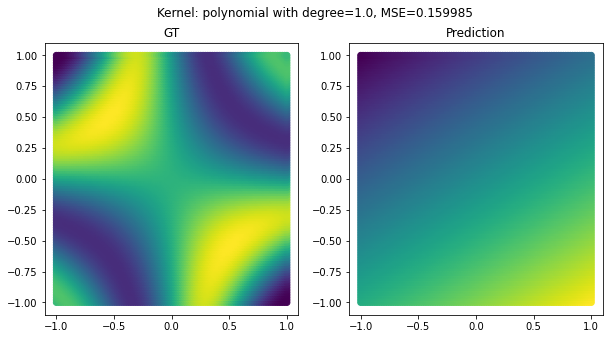

Computation time is:  1.0021912509996582


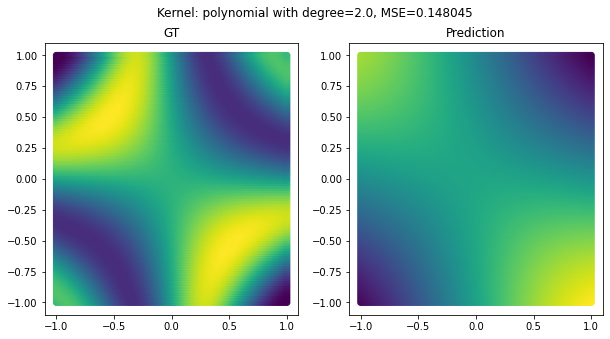

Computation time is:  1.0507099719998223


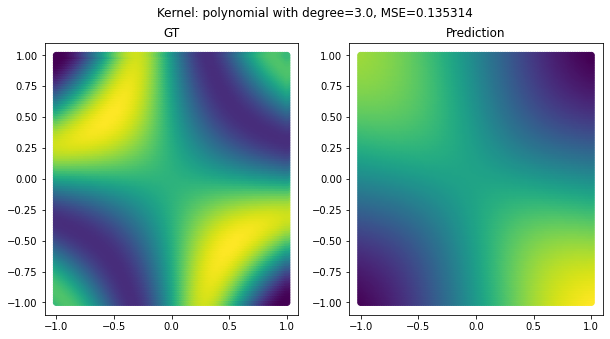

Computation time is:  2.5334207229998356


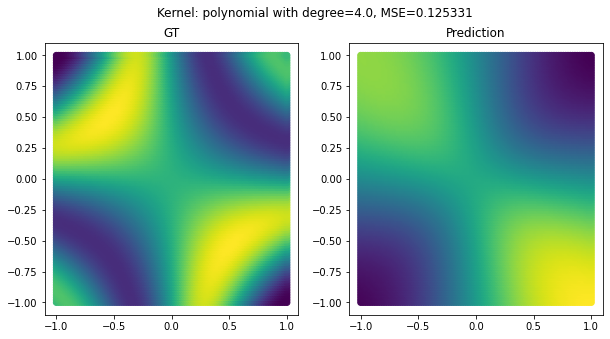

Computation time is:  2.509378491999996


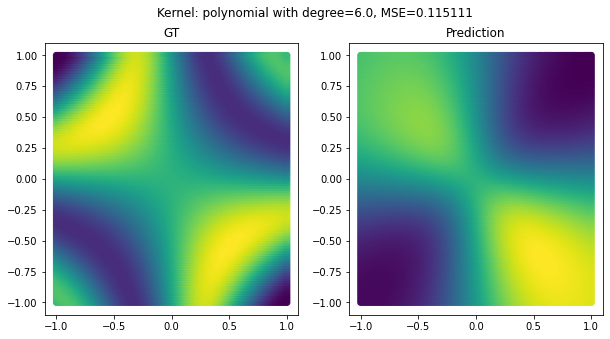

Computation time is:  2.453839750000043


In [ ]:
# polynomial kernel
poly_regre = regressor(kernel='poly')
poly_regre.fit(x_train, y_train)
k=len(d)
poly_mse = np.zeros(k)

for i in range(k):
    begin = timer()
    poly_regre.set_degree(d[i])
    pred = poly_regre.predict(x_test)
    poly_mse[i] = poly_regre.get_MSE(y_test)
    end = timer()
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].scatter(x_test[:, 0], x_test[:, 1], c=y_test)
    ax[0].set_title("GT")
    ax[1].scatter(x_test[:, 0], x_test[:, 1], c=pred)
    ax[1].set_title("Prediction")
    fig.suptitle(r'Kernel: polynomial with degree=%0.01f, MSE=%f' % (d[i], poly_mse[i]))
    plt.show()
    print("Computation time is: ", end - begin)

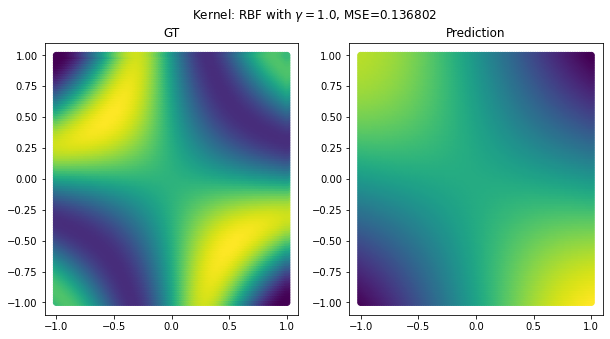

Computation time is:  1.211546177999935


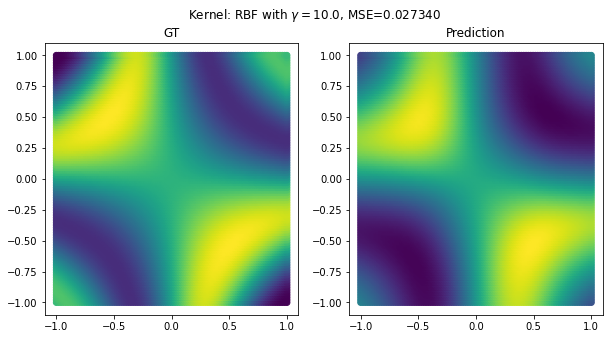

Computation time is:  1.245104192999861


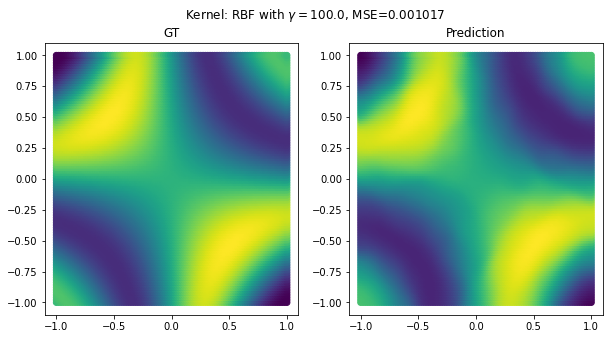

Computation time is:  1.3005999570000313


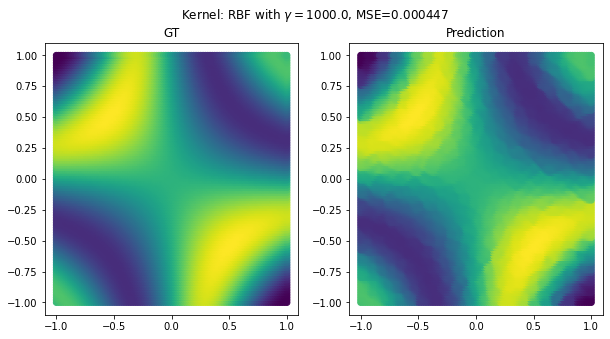

Computation time is:  1.3453174370001761


In [ ]:
# RBF kernel
rbf_regress = regressor(kernel='rbf')
rbf_regress.fit(x_train, y_train)
k=len(gammas)
rbf_mse = np.zeros(k)

for i in range(k):
    begin = timer()
    rbf_regress.set_gamma(gammas[i])
    pred = rbf_regress.predict(x_test)
    rbf_mse[i] = rbf_regress.get_MSE(y_test)
    end = timer()
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].scatter(x_test[:, 0], x_test[:, 1], c=y_test)
    ax[0].set_title("GT")
    ax[1].scatter(x_test[:, 0], x_test[:, 1], c=pred)
    ax[1].set_title("Prediction")
    fig.suptitle(r'Kernel: RBF with $\gamma=$%0.01f, MSE=%f' % (gammas[i], rbf_mse[i]))
    plt.show()
    print("Computation time is: ", end - begin)

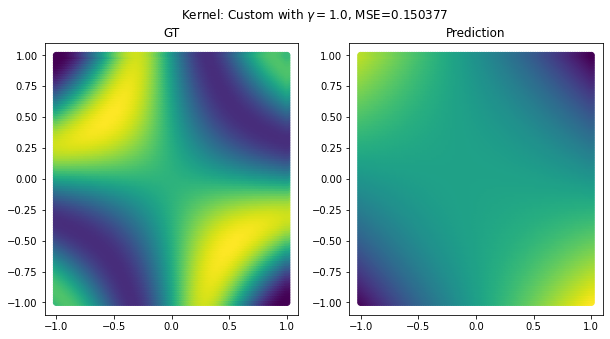

Computation time is:  1.281993410999803


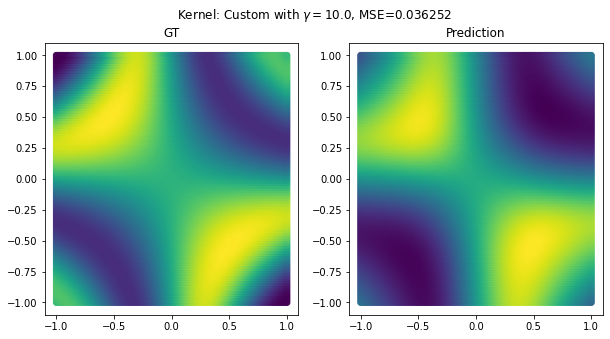

Computation time is:  1.281779135999841


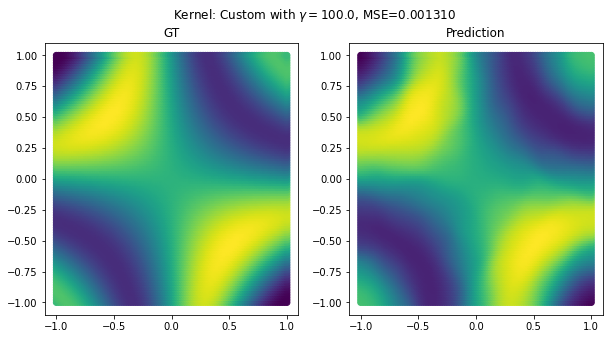

Computation time is:  1.3552709219998178


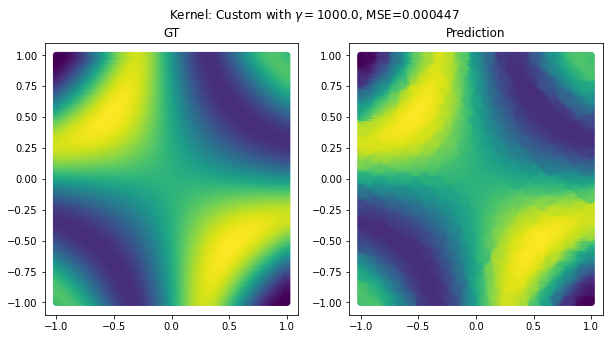

Computation time is:  1.4562417129995993


In [ ]:
# custom kernel
custom_regress = regressor(kernel='custom')
custom_regress.fit(x_train, y_train)
k=len(gammas)
custom_mse = np.zeros(k)

for i in range(k):
    begin = timer()
    custom_regress.set_gamma(gammas[i])
    pred = custom_regress.predict(x_test)
    custom_mse[i] = custom_regress.get_MSE(y_test)
    end = timer()
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].scatter(x_test[:, 0], x_test[:, 1], c=y_test)
    ax[0].set_title("GT")
    ax[1].scatter(x_test[:, 0], x_test[:, 1], c=pred)
    ax[1].set_title("Prediction")
    fig.suptitle(r'Kernel: Custom with $\gamma=$%0.01f, MSE=%f' % (gammas[i], custom_mse[i]))
    plt.show()
    print("Computation time is: ", end - begin)

Part 2 

Locality Sensitive Hashing

In [ ]:
def compute_hashing(input, hash_code, size=5):
    x = input[0]
    y = input[1]
    hashing = 0
    for i in range(size):
        if hash_code[i][0] * x + hash_code[i][1] * y > 0:
            hashing += 2 ** i
    return hashing

def LSH(x_train, y_train, size=5):
    n, dim = x_train.shape
    hash_code = np.zeros([size, 2])
    hash_table = {}
    hash_table_y = {}
    for i in range(size):
        rnd = random.random() * 2 * math.pi
        x_rnd = math.cos(rnd)
        y_rnd = math.sin(rnd)
        hash_code[i][0] = x_rnd
        hash_code[i][1] = y_rnd

    for i in range(n):
        x = x_train[i][0]
        y = x_train[i][1]
        y_tr = y_train[i]
        hashing = 0
        for i in range(size):
            if hash_code[i][0] * x + hash_code[i][1] * y > 0:
                hashing += 2 ** i
        if hashing not in hash_table:
            hash_table[hashing] = []
        hash_table[hashing].append((x, y))
        if hashing not in hash_table_y:
            hash_table_y[hashing] = []
        hash_table_y[hashing].append(y_tr)
    for i in hash_table:
        hash_table[i] = np.asarray(hash_table[i])
    return hash_code, hash_table, hash_table_y

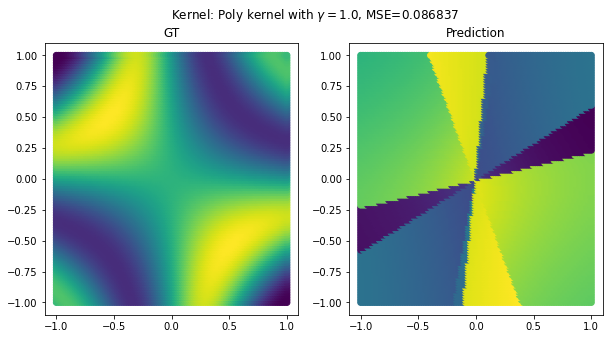

poly kernel computation time with hashing is:  1.0374901089999184


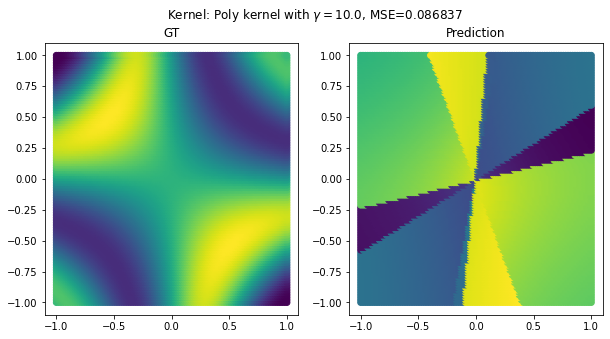

poly kernel computation time with hashing is:  1.0992558059997464


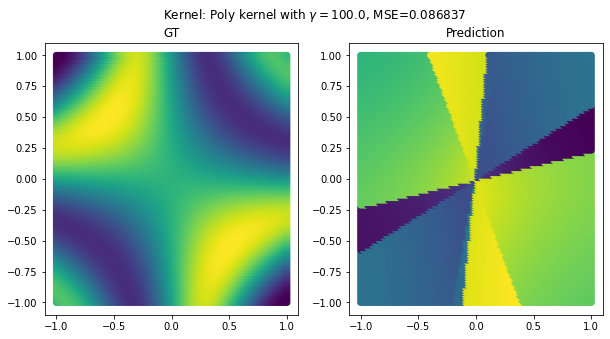

poly kernel computation time with hashing is:  1.0746686229999796


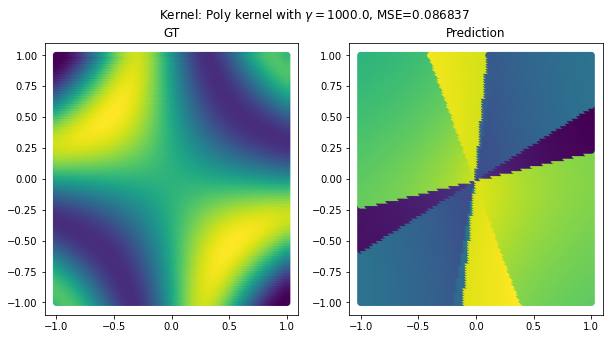

poly kernel computation time with hashing is:  1.1118190249999316


In [ ]:
# poly kernel with Hashing
poly_hash = np.zeros(len(d))
for i in range(len(gammas)):
    begin = timer()
    poly_regre.set_gamma(gammas[i])
    pred = poly_regre.predict_hashing(x_test)
    poly_hash[i] = poly_regre.get_MSE(y_test)
    end = timer()
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].scatter(x_test[:, 0], x_test[:, 1], c=y_test)
    ax[0].set_title("GT")
    ax[1].scatter(x_test[:, 0], x_test[:, 1], c=pred)
    ax[1].set_title("Prediction")
    fig.suptitle(r'Kernel: Poly kernel with $\gamma=$%0.01f, MSE=%f' % (gammas[i], poly_hash[i]))
    plt.show()
    print("poly kernel computation time with hashing is: ", end - begin)

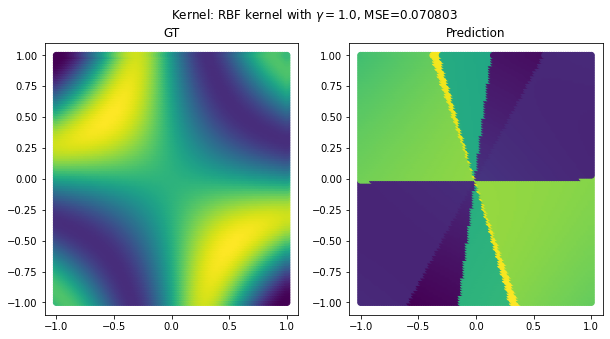

rbf kernel computation time with hashing is:  0.9138664320003045


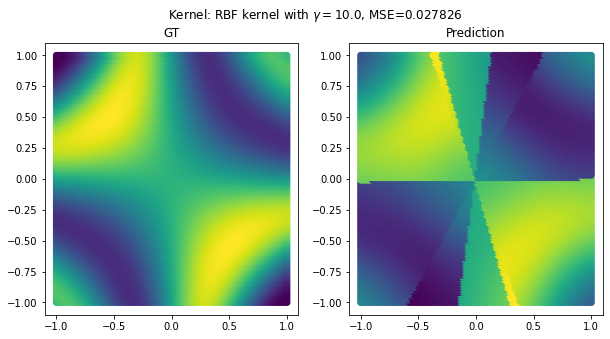

rbf kernel computation time with hashing is:  0.8631059629997253


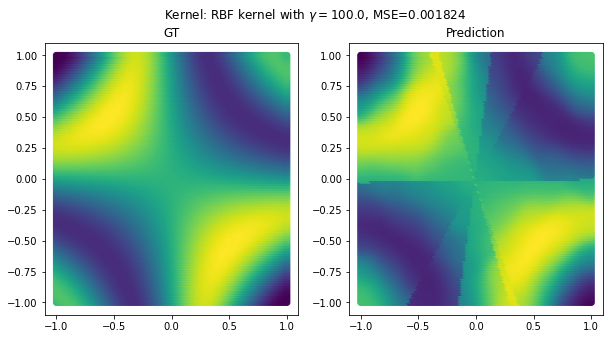

rbf kernel computation time with hashing is:  0.8518748070000584


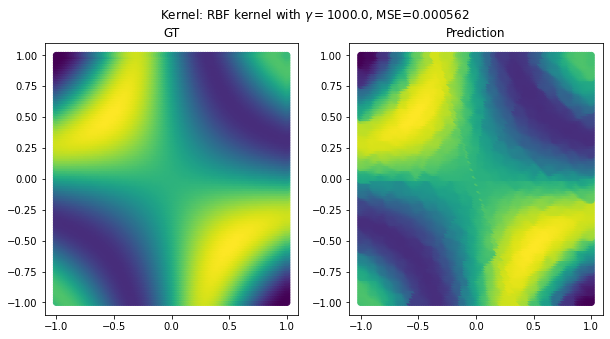

rbf kernel computation time with hashing is:  0.8998578840000846


In [ ]:
# rbf kernel with Hashing
rbf_hash = np.zeros(len(gammas))
for i in range(len(gammas)):
    begin = timer()
    rbf_regress.set_gamma(gammas[i])
    pred = rbf_regress.predict_hashing(x_test)
    rbf_hash[i] = rbf_regress.get_MSE(y_test)
    end = timer()
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].scatter(x_test[:, 0], x_test[:, 1], c=y_test)
    ax[0].set_title("GT")
    ax[1].scatter(x_test[:, 0], x_test[:, 1], c=pred)
    ax[1].set_title("Prediction")
    fig.suptitle(r'Kernel: RBF kernel with $\gamma=$%0.01f, MSE=%f' % (gammas[i], rbf_hash[i]))
    plt.show()
    print("rbf kernel computation time with hashing is: ", end - begin)

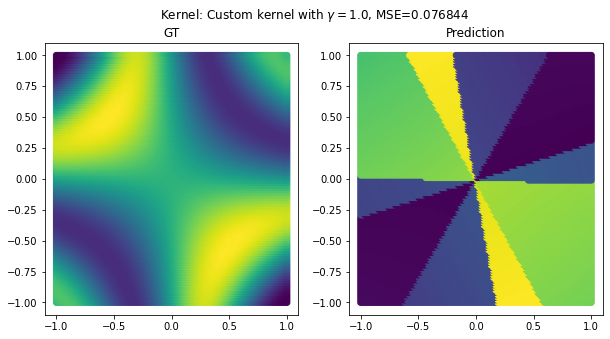

custom kernel computation time with hashing is:  0.8348848040000121


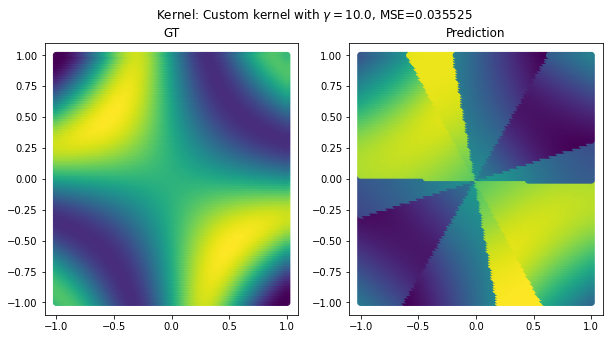

custom kernel computation time with hashing is:  0.8284542229998806


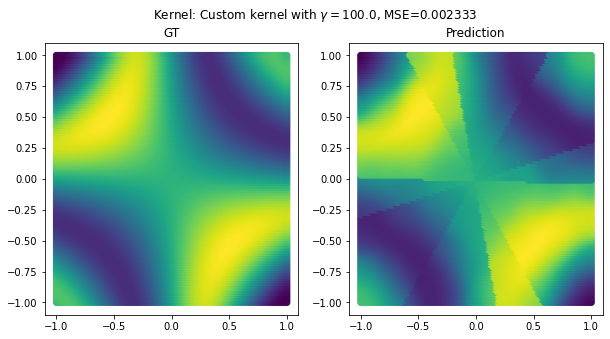

custom kernel computation time with hashing is:  0.8213503450001554


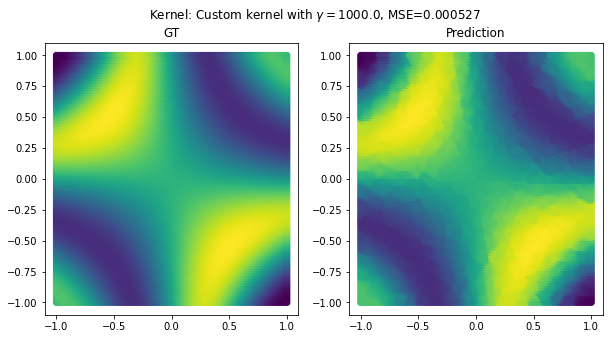

custom kernel computation time with hashing is:  0.8312425499998426


In [ ]:
# custom kernel with Hashing
custom_hash = np.zeros(len(gammas))
for i in range(len(gammas)):
    begin = timer()
    custom_regress.set_gamma(gammas[i])
    pred = custom_regress.predict_hashing(x_test)
    custom_hash[i] = custom_regress.get_MSE(y_test)
    end = timer()
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].scatter(x_test[:, 0], x_test[:, 1], c=y_test)
    ax[0].set_title("GT")
    ax[1].scatter(x_test[:, 0], x_test[:, 1], c=pred)
    ax[1].set_title("Prediction")
    fig.suptitle(r'Kernel: Custom kernel with $\gamma=$%0.01f, MSE=%f' % (gammas[i], custom_hash[i]))
    plt.show()
    print("custom kernel computation time with hashing is: ", end - begin)

In [ ]:
# run custom kernel for 10 times
time_hash = 0
for i in range(10):
    begin = timer()
    custom_regress.fit(x_train, y_train)
    custom_regress.set_gamma(1000)
    pred = custom_regress.predict_hashing(x_test)
    custom_mse = custom_regress.get_MSE(y_test)
    end = timer()
    time_hash += end - begin
print("Average time for custom kernel with LSH is: ", time_hash / 10)

time = 0
for i in range(10):
    begin = timer()
    custom_regress.fit(x_train, y_train)
    custom_regress.set_gamma(1000)
    pred = custom_regress.predict(x_test)
    custom_mse = custom_regress.get_MSE(y_test)
    end = timer()
    time += end - begin
print("Average time for custom kernel without LSH is: ", time / 10)

Average time for custom kernel with LSH is:  0.9633387736999339
Average time for custom kernel without LSH is:  1.4285976084998766
